In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

In [2]:
# Specify the path to your text file
file_path = 'TIC13955147/hlsp_tess-spoc_tess_phot_0000000013955147-s0031_tess_v1_tp/hlsp_tess-spoc_tess_phot_0000000013955147-s0031_tess_v1_lc_new_FLARE.txt'
# Get the directory from the file path
directory = os.path.dirname(file_path)

base_name = os.path.basename(file_path)
first_element = file_path.split('/')[0]  # "TIC269797536"
second_element = base_name.split('_')[3].split('-')[0]  # "s0031"

# Read the file explicitly specifying tab ('\t') as the delimiter
df = pd.read_csv(file_path, delimiter='\t')

# Check the first few rows to verify the columns are properly separated
print(df.head())


          TIME  PDCSAP_FLUX  PDCSAP_FLUX_ERR  FLARE_HB  FLARE_BH  \
0  2144.519703     -999.000      -999.000000         0         0   
1  2144.526648    50586.492        11.702390         0         0   
2  2144.533592    50582.990        11.706409         0         0   
3  2144.540537    50587.460        11.702420         0         0   
4  2144.547482    50592.883        11.704536         0         0   

   FLARE_candidate  DE-HARMONIC         Zt  epsilont        pp  
0                0  -999.000000   0.000000  0.000000  0.000000  
1                0   -20.153772 -23.462299 -1.101738  1.796552  
2                0   -23.830985 -11.207111 -0.419631  1.371898  
3                0   -19.531254  -5.256522 -0.260469  1.236335  
4                0   -14.282725  -3.789599 -0.207947  1.189703  


In [3]:
import numpy as np

DEHAR = df['DE-HARMONIC']

minus_one_mask = DEHAR == -999

minus_one_indices = DEHAR.index[minus_one_mask]

if len(minus_one_indices) == 0:
    print("No -1 values found in the 'DE-HARMONIC' column.")
else:
    # Find the differences between successive indices
    diffs = np.diff(minus_one_indices)

    # Identify where the difference is greater than 1 (non-consecutive indices)
    split_points = np.where(diffs > 1)[0]

    # Add start and end points for indexing
    split_points = np.concatenate(([0], split_points + 1, [len(minus_one_indices)]))

    # Extract start and end indices for consecutive -1 sequences
    consecutive_minus_one_ranges = [(minus_one_indices[start], minus_one_indices[end - 1])
                                    for start, end in zip(split_points[:-1], split_points[1:])]

    print("Start and end indices of consecutive -999 values:", consecutive_minus_one_ranges)


max_difference = -1
max_tuple = None

for tup in consecutive_minus_one_ranges:
    diff = tup[1] - tup[0]  
    if diff > max_difference:
        max_difference = diff
        max_tuple = tup

first_number, last_number = max_tuple
print(f"The tuple with the largest difference is: {max_tuple}")
print(f"The first number is: {first_number}, and the last number is: {last_number}")

Start and end indices of consecutive -999 values: [(np.int64(0), np.int64(0)), (np.int64(12), np.int64(13)), (np.int64(920), np.int64(923)), (np.int64(1760), np.int64(2065)), (np.int64(2070), np.int64(2071)), (np.int64(3005), np.int64(3008))]
The tuple with the largest difference is: (np.int64(1760), np.int64(2065))
The first number is: 1760, and the last number is: 2065


In [4]:
start_index = first_number
end_index = last_number

In [5]:
# Step 1: Identify values that are not -1
is_not_minus_one = DEHAR != -999

# Step 2: Find the index of the first non -1 value
start = is_not_minus_one.idxmax()

# Step 3: Reverse the series to find the index of the last non -1 value
end = is_not_minus_one[::-1].idxmax()

# Output the start and end indices of non -1 values
start, end


(1, 3661)

In [6]:
df.replace(-999, np.nan, inplace=True)
print(df.head())

mask = df['DE-HARMONIC'].isna()
df.loc[mask, ['FLARE_HB', 'FLARE_BH', 'FLARE_candidate']] = 0


          TIME  PDCSAP_FLUX  PDCSAP_FLUX_ERR  FLARE_HB  FLARE_BH  \
0  2144.519703          NaN              NaN         0         0   
1  2144.526648    50586.492        11.702390         0         0   
2  2144.533592    50582.990        11.706409         0         0   
3  2144.540537    50587.460        11.702420         0         0   
4  2144.547482    50592.883        11.704536         0         0   

   FLARE_candidate  DE-HARMONIC         Zt  epsilont        pp  
0                0          NaN   0.000000  0.000000  0.000000  
1                0   -20.153772 -23.462299 -1.101738  1.796552  
2                0   -23.830985 -11.207111 -0.419631  1.371898  
3                0   -19.531254  -5.256522 -0.260469  1.236335  
4                0   -14.282725  -3.789599 -0.207947  1.189703  


In [7]:
t1 = df['TIME'].values[start:start_index]  
y1 = df['PDCSAP_FLUX'].ffill().bfill().values[start:start_index]
t2 = df['TIME'].values[end_index+1:end] 
y2 = df['PDCSAP_FLUX'].ffill().bfill().values[end_index+1:end]

err1 = df['PDCSAP_FLUX_ERR'].ffill().bfill().values[start:start_index]
err2 = df['PDCSAP_FLUX_ERR'].ffill().bfill().values[end_index+1:end]
epsilon_1 = df['epsilont'].ffill().bfill().values[start:start_index]
epsilon_2 = df['epsilont'].ffill().bfill().values[end_index+1:end]
z_1 = df['Zt'].ffill().bfill().values[start:start_index]
z_2 = df['Zt'].ffill().bfill().values[end_index+1:end]
flare_bh_1 = df.loc[start:start_index-1, 'FLARE_BH']
flare_hb_1 = df.loc[start:start_index-1, 'FLARE_HB']
flare_bh_1_indices = flare_bh_1[flare_bh_1 == 1].index.values
flare_hb_1_indices = flare_hb_1[flare_hb_1 == 1].index.values

flare_bh_2 = df.loc[end_index+1:end-1, 'FLARE_BH']
flare_bh_2_indices = flare_bh_2[flare_bh_2 == 1].index.values

dehar_1 = df['DE-HARMONIC'].ffill().bfill().values[start:start_index]
dehar_2 = df['DE-HARMONIC'].ffill().bfill().values[end_index+1:end]

fit1 = y1.copy() - dehar_1
fit2 = y2.copy() - dehar_2

In [8]:
# Extract the subset from the original DataFrame using .loc for label-based slicing
original_subset = df.loc[start:start_index-1, 'FLARE_BH']

# Filter the original subset to get indices where FLARE_BH equals 1
original_flare_bh_indices = original_subset[original_subset == 1].index.values

# Now compare with flare_bh_1_indices
if np.array_equal(flare_bh_1_indices, original_flare_bh_indices):
    print("Indices match!")
else:
    print("Mismatch in indices.")


Indices match!


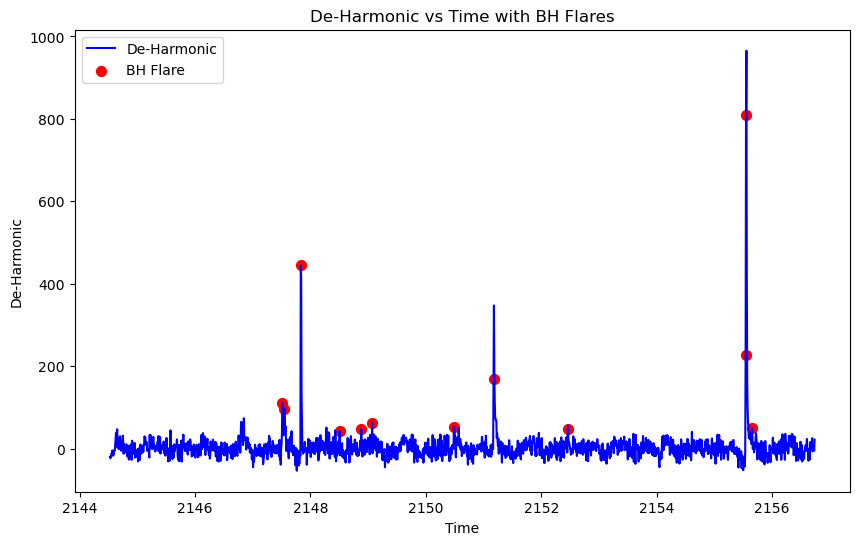

In [9]:
# Get the subset of rows using .loc (note: .loc slicing is label-inclusive)
subset = df.loc[start:start_index-1].copy()

# Make sure DE-HARMONIC is properly filled (if needed)
subset['DE-HARMONIC'] = subset['DE-HARMONIC'].ffill().bfill()

# Plot the deharmonic as a line
plt.figure(figsize=(10, 6))
plt.plot(subset['TIME'], subset['DE-HARMONIC'], label='De-Harmonic', color='blue')

# Identify rows where FLARE_BH equals 1
flare_bh_subset = subset[subset['FLARE_BH'] == 1]

# Overlay the flare points as a scatter plot
plt.scatter(flare_bh_subset['TIME'], flare_bh_subset['DE-HARMONIC'],
            color='red', marker='o', s=50, label='BH Flare')

plt.xlabel('Time')
plt.ylabel('De-Harmonic')
plt.title('De-Harmonic vs Time with BH Flares')
plt.legend()
plt.show()

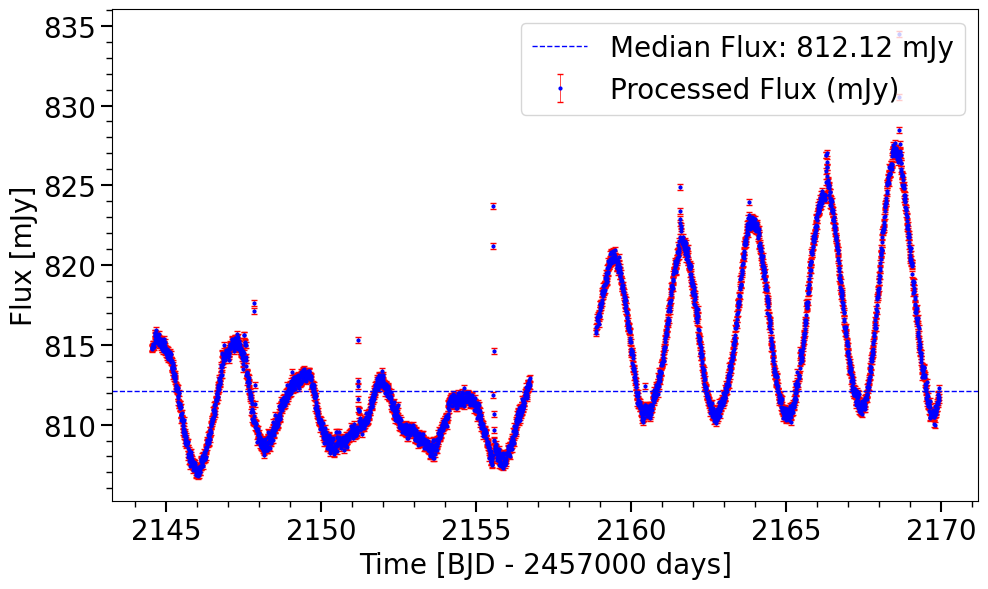

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator  # Import AutoMinorLocator

# Constants
CONVERSION_FACTOR = 0.016106667  # mJy per count per second
#CONVERSION_FACTOR = 1
# Data Transformation
df['PDCSAP_FLUX_MJY'] = df['PDCSAP_FLUX'] * CONVERSION_FACTOR  # Convert flux to mJy
df['PDCSAP_FLUX_ERR_MJY'] = df['PDCSAP_FLUX_ERR'] * CONVERSION_FACTOR  # Convert flux error to mJy

# Extract columns for plotting
time = df['TIME'].values  # Barycentric Julian Days
flux_mjy = df['PDCSAP_FLUX_MJY'].values  # Flux in mJy
flux_err_mjy = df['PDCSAP_FLUX_ERR_MJY'].values  # Flux error in mJy

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(
    time, flux_mjy, yerr=flux_err_mjy, fmt='o', color='blue', ecolor='red', elinewidth=0.5, capsize=2, markersize=2,
    label='Processed Flux (mJy)'
)

# Add the median flux as a blue dashed line
median_flux = np.nanmedian(flux_mjy)
plt.axhline(median_flux, color='blue', linestyle='--', linewidth=1, label=f'Median Flux: {median_flux:.2f} mJy')

# Customize the plot
plt.xlabel("Time [BJD - 2457000 days]", fontsize=20)
plt.ylabel("Flux [mJy]", fontsize=20)
plt.legend(loc='upper right', fontsize=20)

# Add more ticks
ax = plt.gca()
ax.tick_params(axis='both', which='major', length=8, width=1.5, labelsize=20)  # Major ticks
ax.tick_params(axis='both', which='minor', length=4, width=1)  # Minor ticks

# Enable minor ticks
ax.minorticks_on()

# Adjust minor ticks location and density
ax.xaxis.set_minor_locator(AutoMinorLocator(5))  # 5 minor ticks per major tick interval on x-axis
ax.yaxis.set_minor_locator(AutoMinorLocator(5))  # 5 minor ticks per major tick interval on y-axis

# Save and show the plot
plt.tight_layout()
plt.savefig("TIC_13955147_s0031_flux_light_curve.pdf", dpi=300)
plt.show()


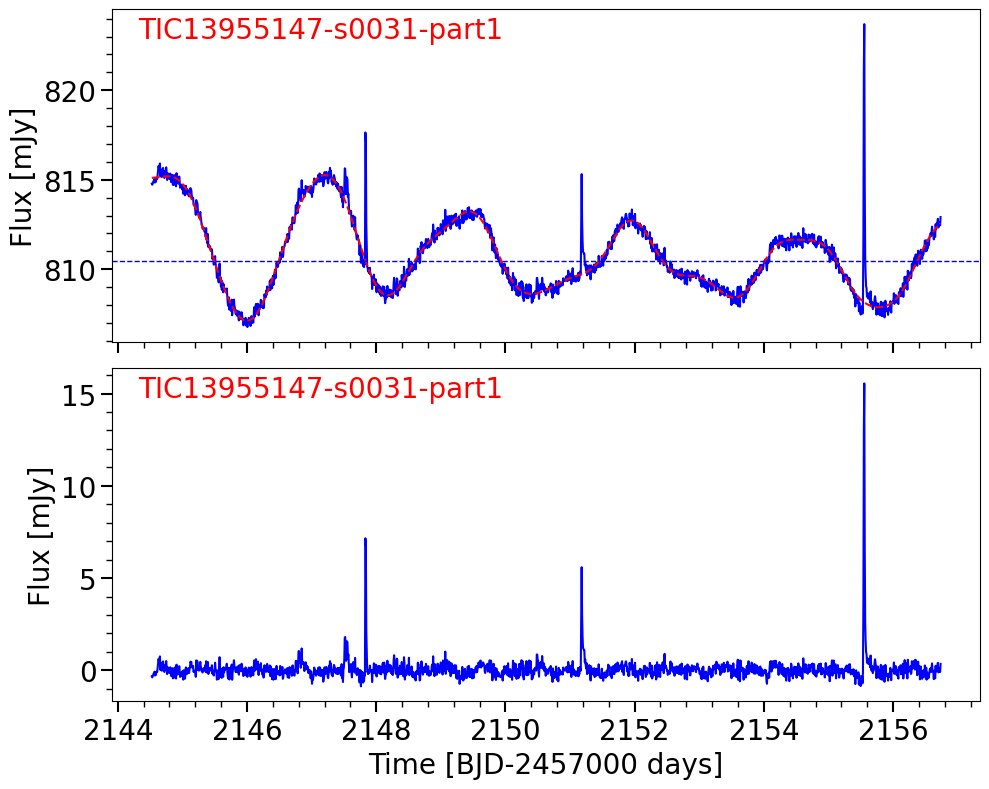

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# Create a figure and two subplots sharing the same X axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# ---------------------- TOP SUBPLOT ----------------------
# Plot 1: Original Data and Best Fit
ax1.plot(t1, y1 * CONVERSION_FACTOR, 'blue', label='Original Data')
ax1.plot(t1, fit1 * CONVERSION_FACTOR, 'r--', label='Harmonic Fit')
flux_mjy = df['PDCSAP_FLUX_MJY'].values[start:start_index]
median_flux = np.nanmedian(flux_mjy)
ax1.axhline(median_flux, color='blue', linestyle='--', linewidth=1, label=f'Median Flux: {median_flux:.2f} mJy')


# Y-axis label for the top subplot
ax1.set_ylabel("Flux [mJy]", fontsize=20)

# Customize ticks on the top subplot
ax1.tick_params(axis='both', which='major', length=8, width=1.5, labelsize=20)
ax1.tick_params(axis='both', which='minor', length=4, width=1)
ax1.minorticks_on()

# Set minor tick locators (5 minor ticks per major interval)
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))

# Add red text in the top-left corner of the top subplot
ax1.text(
    0.03, 0.98, "TIC13955147-s0031-part1", color='red', fontsize=20,
    transform=ax1.transAxes, va='top', ha='left'
)

# ---------------------- BOTTOM SUBPLOT ----------------------
# Plot 2: Residuals
ax2.plot(t1, dehar_1 * CONVERSION_FACTOR, 'blue', label='Residuals')

# X-axis and Y-axis labels for the bottom subplot
ax2.set_xlabel("Time [BJD-2457000 days]", fontsize=20)
ax2.set_ylabel("Flux [mJy]", fontsize=20)

# Customize ticks on the bottom subplot
ax2.tick_params(axis='both', which='major', length=8, width=1.5, labelsize=20)
ax2.tick_params(axis='both', which='minor', length=4, width=1)
ax2.minorticks_on()
ax2.text(
    0.03, 0.98, "TIC13955147-s0031-part1", color='red', fontsize=20,
    transform=ax2.transAxes, va='top', ha='left'
)

# Set minor tick locators (5 minor ticks per major interval)
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))

# ---------------------- FINAL LAYOUT & SAVE ----------------------
# Tighten layout to reduce overlapping
plt.tight_layout()

# Save the figure (adjust filename and DPI as desired)
plt.savefig('TIC_13955147_s0031_1_deharmonic.pdf', dpi=300)

# Show the combined figure
plt.show()


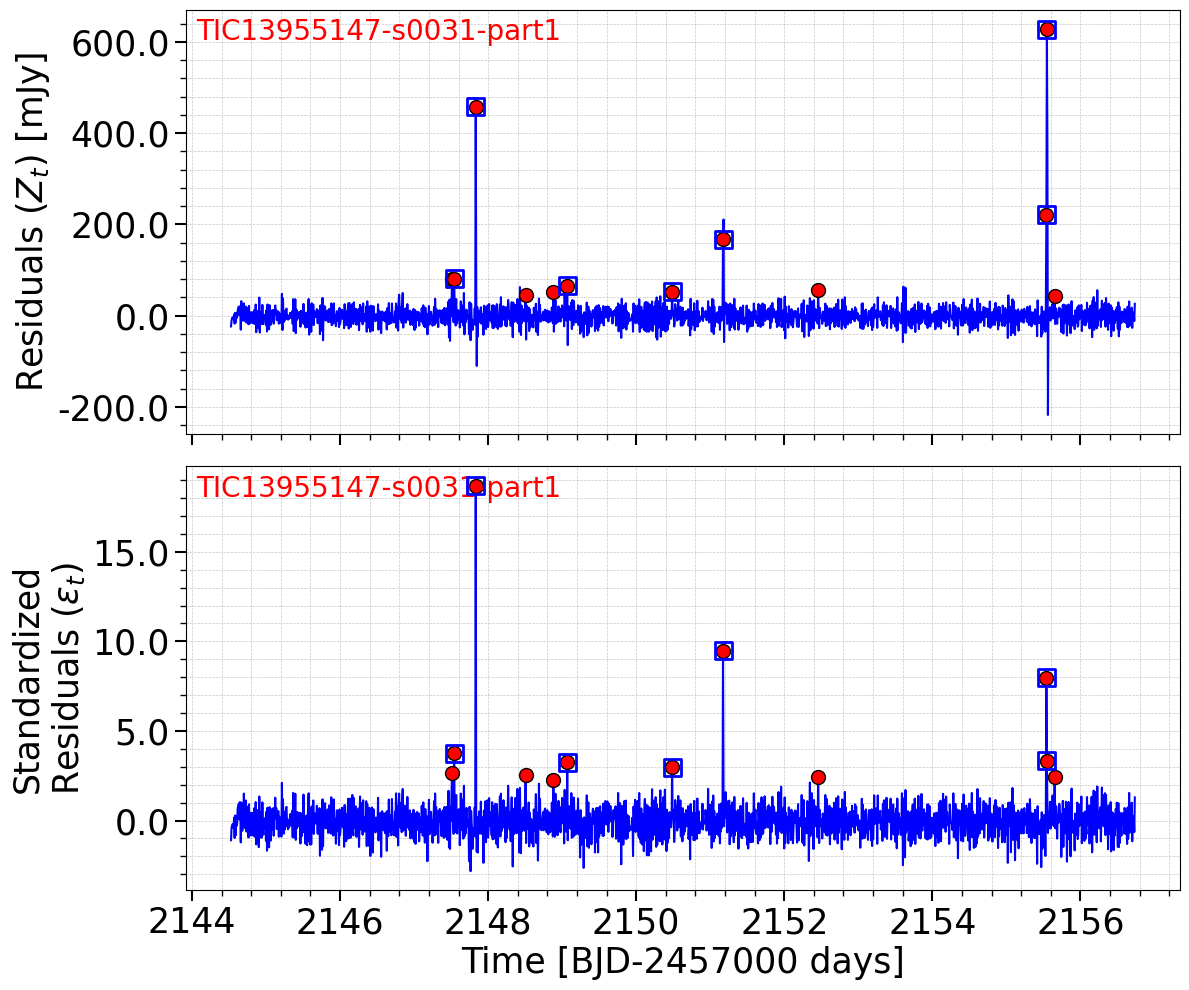

In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter
import matplotlib.patches as mpatches  # For custom legend patches if needed
import numpy as np

# ---------------- Parameters and Data Preparation ----------------

# Define font sizes
title_fontsize = 25
label_fontsize = 25
tick_fontsize = 25  # Updated tick font size

# Assume these variables are already defined:
# t1: Time values for the slice (from df['TIME'].values[start:start_index])
# dehar_1: De-harmonic values for the slice (from df['DE-HARMONIC'] for the same slice)
# epsilon_1: Standardized residuals (from df['epsilont'] for the same slice)
# flare_bh_1_indices: Original DataFrame indices where FLARE_BH == 1 in the slice
# flare_hb_1_indices: Original DataFrame indices where FLARE_HB == 1 in the slice
# start: the starting row index of the slice in the DataFrame
# CONVERSION_FACTOR: a constant to scale your residuals (defined elsewhere)

# For clarity in this example, we assign:
time = t1  # t1 is the sliced time array

# flares indices from the original DataFrame
flares_bh = flare_bh_1_indices  # BH procedure indices
flares_hb = flare_hb_1_indices  # Holm-Bonferroni indices

# Scale the residuals using the conversion factor
deharmonic_residuals = dehar_1 * CONVERSION_FACTOR
standardized_residuals = epsilon_1

# Convert the original DataFrame indices to positions within the slice.
# Since t1 corresponds to rows from 'start' to 'start_index-1',
# subtract 'start' from the indices.
relative_flares_bh = flares_bh - start
relative_flares_hb = flares_hb - start

# ---------------- Plotting ----------------

# Create the figure and axes (2 panels sharing the x-axis)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplots_adjust(hspace=0.3)

# ---------------- Panel (b): Deharmonic Residuals ----------------
axes[0].plot(time, z_1, label="Residuals ($X_t$)", color="blue")

# Scatter plot for flares detected by BH procedure (red circles)
axes[0].scatter(
    time[relative_flares_bh], 
    z_1[relative_flares_bh], 
    color="red", 
    label="Detected Flares (BH)", 
    s=100,            # Size of red dots
    edgecolors='k',   # Black edges for better visibility
    zorder=3         # Plot on top of the line
)

# Scatter plot for flares detected by Holm-Bonferroni procedure (blue squares)
axes[0].scatter(
    time[relative_flares_hb], 
    z_1[relative_flares_hb], 
    facecolors='none',   # Hollow squares
    edgecolors="blue", 
    label="Detected Flares (HB)", 
    marker='s',         # Square marker
    s=150,              # Size of blue squares
    linewidths=2,       # Thickness of square edges
    zorder=4            # Plot on top of the BH flares
)

axes[0].set_ylabel("Residuals ($Z_t$) [mJy]", fontsize=label_fontsize)
axes[0].tick_params(axis='both', which='major', length=8, width=1.5, labelsize=tick_fontsize)
axes[0].tick_params(axis='both', which='minor', length=4, width=1)
axes[0].minorticks_on()
axes[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axes[0].yaxis.set_minor_locator(AutoMinorLocator(5))
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Add red text in the top-left corner
axes[0].text(
    0.01, 0.98, "TIC13955147-s0031-part1", color='red', fontsize=20,
    transform=axes[0].transAxes, va='top', ha='left'
)

# ---------------- Panel (c): Standardized Residuals ----------------
axes[1].plot(time, standardized_residuals, label="Standardized Residuals ($\\varepsilon_t$)", color="blue")

# Scatter plot for flares detected by BH procedure (red circles)
axes[1].scatter(
    time[relative_flares_bh], 
    standardized_residuals[relative_flares_bh], 
    color="red", 
    label="Detected Flares (BH)", 
    s=100,
    edgecolors='k',
    zorder=3
)

# Scatter plot for flares detected by Holm-Bonferroni procedure (blue squares)
axes[1].scatter(
    time[relative_flares_hb], 
    standardized_residuals[relative_flares_hb], 
    facecolors='none', 
    edgecolors="blue", 
    label="Detected Flares (HB)", 
    marker='s', 
    s=150, 
    linewidths=2, 
    zorder=4
)

axes[1].set_xlabel("Time [BJD-2457000 days]", fontsize=label_fontsize)
axes[1].set_ylabel("Standardized\nResiduals ($\\varepsilon_t$)", fontsize=label_fontsize)
axes[1].tick_params(axis='both', which='major', length=8, width=1.5, labelsize=tick_fontsize)
axes[1].tick_params(axis='both', which='minor', length=4, width=1)
axes[1].minorticks_on()
axes[1].xaxis.set_minor_locator(AutoMinorLocator(5))
axes[1].yaxis.set_minor_locator(AutoMinorLocator(5))
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Add red text in the top-left corner
axes[1].text(
    0.01, 0.98, "TIC13955147-s0031-part1", color='red', fontsize=20,
    transform=axes[1].transAxes, va='top', ha='left'
)

# ---------------- Optional Legends and Grid ----------------

# Uncomment the following lines if you wish to display legends:
# axes[0].legend(fontsize=label_fontsize, loc='upper right')
# axes[1].legend(fontsize=label_fontsize, loc='upper right')

# Enable grid on both subplots
for ax in axes:
    ax.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()

# Save and show the figure
plt.savefig("TIC_13955147_s0031_1_flares_analysis.pdf", dpi=300)
plt.show()


In [13]:
time[flares_hb - 1]

array([2147.54061912, 2147.83229298, 2149.0684333 , 2150.48513107,
       2151.17264531, 2155.54077844, 2155.54772299])

In [14]:
eps_all = df['epsilont']
ofl_all = df.index[df['FLARE_candidate'] == 1]
ofl_all = df[df['FLARE_candidate'] == 1].index.tolist()

In [15]:
def flare_detection(epsilont, alphathr):
    """
    Detects flares in the given epsilon_t array using statistical methods.
    
    Parameters:
    epsilont : numpy.ndarray
        Array of epsilon_t values.
    alphathr : float
        Significance level threshold (alpha).
    
    Returns:
    dict
        Dictionary containing tsig, p-values, and indices of rejections for BH and Holm methods.
    """
    # Step 1: Select valid negative epsilont
    o0 = np.where((epsilont <= 0) & (epsilont != -1))[0]  # Indices where epsilont <= 0 and epsilont != -1
    mo0 = len(o0)  # Number of valid negative epsilont values

    if mo0 == 0:
        raise ValueError("No valid negative epsilont values found (epsilont <= 0 and epsilont != -1).")

    # Step 2: Compute tsig (standard deviation extrapolated from epsilont < 0 by reflecting it)
    tmp = np.concatenate([epsilont[o0], -epsilont[o0]])  # Reflect negative epsilont values
    tsig = np.std(tmp, ddof=1)  # Compute standard deviation

    # Step 3: Fit a normal distribution to tmp and compute the upper quantile
    mu, sigma = norm.fit(tmp)  # Fit normal distribution to tmp
    upper_quantile = norm.ppf(1 - alphathr, loc=mu, scale=sigma)  # 1 - alpha threshold

    # Step 4: Identify candidate flares (indices where epsilont > upper quantile)
    ofl1 = np.where(epsilont > upper_quantile)[0]
    mofl1 = len(ofl1)  # Number of candidate flares

    if mofl1 == 0:
        # No candidate flares found; return empty results
        return {
            'tsig': tsig,
            'p_values': np.array([]),
            'BH_pBH': None,
            'BH_rejections_indices': np.array([], dtype=int),
            'HB_pHB': None,
            'HB_rejections_indices': np.array([], dtype=int)
        }

    # Step 5: Compute p-values based on epsilont width
    tmp1 = epsilont[ofl1]
    pp_raw = 1.0 - erf((tmp1 / tsig) / np.sqrt(2.0))
    pp = np.maximum(pp_raw, alphathr / (mofl1 * 8.0))  # Ensure p-values are not too small

    # Step 6: Index list of candidate flares
    ip = np.arange(mofl1)  # Index list

    # Step 7: Sort p-values
    os = np.argsort(pp)  # Indices that would sort pp
    spp = pp[os]  # Sorted p-values
    sii = np.arange(1, mofl1 + 1)  # Sequence from 1 to mofl1
    sip = ip[os]  # Sorted indices of candidate flares

    # Step 8: Compute thresholds for BH and Holm methods
    BHthr = alphathr * sii / float(mofl1)  # Benjamini-Hochberg FDR threshold
    HBthr = alphathr / (mofl1 - sii + 1.0)  # Holm-Bonferroni FWER threshold

    # Step 9: Benjamini-Hochberg FDR
    kBH = -1
    for i in range(mofl1 - 1, -1, -1):
        if spp[i] <= BHthr[i]:
            kBH = i
            break
    if kBH >= 0:
        pBH = spp[kBH]
        bh_rejections = sip[:kBH + 1]  # Indices of rejections
    else:
        pBH = spp.min() / 10.0
        bh_rejections = np.array([], dtype=int)

    # Step 10: Holm-Bonferroni FWER
    kHB = -1
    for i in range(mofl1):
        if spp[i] > HBthr[i]:
            kHB = i
            break
    if kHB > 0:
        pHB = HBthr[kHB]
        hb_rejections = sip[:kHB]
    elif kHB == 0:
        pHB = spp[0]
        hb_rejections = np.array([], dtype=int)
    else:
        pHB = spp.min() / 10.0
        hb_rejections = sip  # All hypotheses rejected

    # Map rejections back to original indices in epsilont
    bh_rejections_indices = ofl1[bh_rejections]
    hb_rejections_indices = ofl1[hb_rejections]

    # Return results
    return {
        'tsig': tsig,
        'p_values': pp,
        'BH_pBH': pBH,
        'BH_rejections_indices': bh_rejections_indices,
        'HB_pHB': pHB,
        'HB_rejections_indices': hb_rejections_indices
    }

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import erf
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy.stats import norm


# Assuming df is your DataFrame with 'epsilont' and 'FLARE_candidate' columns
# and flare_detection function is already defined as provided

# Step 1: Extract epsilon values and flare candidate positions
eps_all = df['epsilont'].values

# Extract integer positions where 'FLARE_candidate' == 1
ofl_all_pos = np.where(df['FLARE_candidate'] == 1)[0]
ofl_all_pos = np.array(ofl_all_pos)

# Step 2: Set the significance threshold
alphathr = 0.05

# Step 3: Run the flare detection
results = flare_detection(eps_all, alphathr)

# Step 4: Extract p-values from results
p_values = results['p_values']

# Step 5: Check if there are any p-values to plot
if len(p_values) == 0:
    print("No flare candidates found to plot.")
else:
    # Step 6: Sort p-values in ascending order
    sorted_indices = np.argsort(p_values)
    sorted_p_values = p_values[sorted_indices]
    ranks = np.arange(1, len(sorted_p_values) + 1)

    


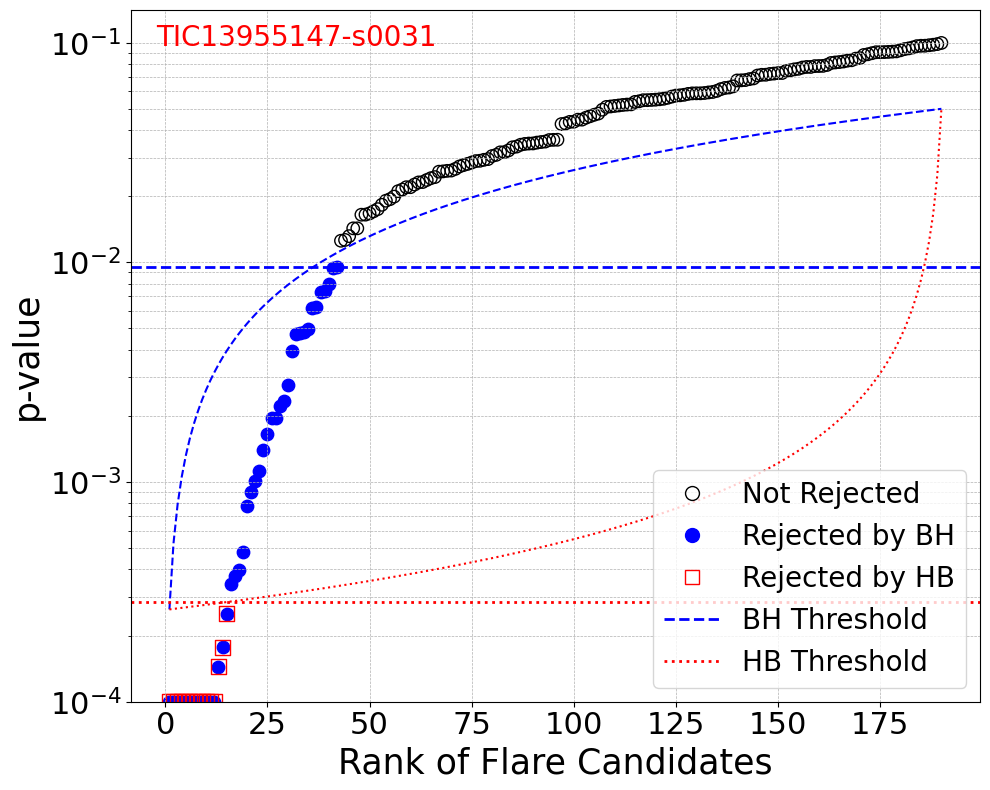

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines  # For custom legend handles
from scipy.special import erf
from scipy.stats import norm

# Extract data
eps_all = df['epsilont'].values
ofl_all_pos = np.where(df['FLARE_candidate'] == 1)[0]
alphathr = 0.05

# Run flare detection
results = flare_detection(eps_all, alphathr)
p_values = results['p_values']

if len(p_values) == 0:
    print("No flare candidates found to plot.")
else:
    sorted_indices = np.argsort(p_values)
    sorted_p_values = p_values[sorted_indices]
    ranks = np.arange(1, len(sorted_p_values) + 1)

    # Group p-values below a cutoff for display
    cutoff_value = 1e-4
    below_cutoff_mask = sorted_p_values < cutoff_value
    n_below_cutoff = np.sum(below_cutoff_mask)
    if n_below_cutoff > 0:
        sorted_p_values[below_cutoff_mask] = cutoff_value

    pBH = results['BH_pBH']
    pHB = results['HB_pHB']

    BHthr = alphathr * ranks / len(ranks)
    HBthr = alphathr / (len(ranks) - ranks + 1.0)

    fig, ax = plt.subplots(figsize=(10, 8))

    # Determine rejection indices
    if pBH is not None:
        bh_rejected = sorted_p_values <= pBH
    else:
        bh_rejected = np.zeros(len(ranks), dtype=bool)
    if pHB is not None:
        hb_rejected = sorted_p_values <= pHB
    else:
        hb_rejected = np.zeros(len(ranks), dtype=bool)

    # Non-rejected: those not meeting the BH threshold
    non_rejected = ~bh_rejected

    # Plot non-rejected candidates as black circles (hollow)
    ax.scatter(ranks[non_rejected], sorted_p_values[non_rejected],
               facecolors='none', edgecolors='black', marker='o', s=80)

    # Plot BH rejected candidates as blue dots
    ax.scatter(ranks[bh_rejected], sorted_p_values[bh_rejected],
               color='blue', marker='o', s=80)

    # Overlay HB rejected candidates with red hollow squares
    ax.scatter(ranks[hb_rejected], sorted_p_values[hb_rejected],
               facecolors='none', edgecolors='red', marker='s', s=120)

    # Plot threshold curves and horizontal threshold lines
    ax.plot(ranks, BHthr, linestyle='--', color='blue', label='BH Curve')
    ax.plot(ranks, HBthr, linestyle=':', color='red', label='HB Curve')
    if pBH is not None:
        ax.axhline(y=pBH, color='blue', linestyle='--', linewidth=2, label='BH Threshold')
    if pHB is not None:
        ax.axhline(y=pHB, color='red', linestyle=':', linewidth=2, label='HB Threshold')

    ax.set_yscale('log')
    ax.set_xlabel('Rank of Flare Candidates', fontsize=25)
    ax.set_ylabel('p-value', fontsize=25)
    ax.tick_params(axis='both', labelsize=22)
    # Adjust lower limit of y-axis (keeping current upper limit)
    ax.set_ylim(1e-4, ax.get_ylim()[1])

    # Custom legend handles
    not_rejected_handle = mlines.Line2D([], [], color='none', marker='o',
                                        markeredgecolor='black', markersize=10, label='Not Rejected')
    bh_rejected_handle = mlines.Line2D([], [], color='blue', marker='o',
                                       linestyle='None', markersize=10, label='Rejected by BH')
    hb_rejected_handle = mlines.Line2D([], [], color='none', marker='s',
                                       markeredgecolor='red', markersize=10, label='Rejected by HB')
    bh_curve_handle = mlines.Line2D([], [], linestyle='--', color='blue',
                                    linewidth=2, label='BH Threshold')
    hb_curve_handle = mlines.Line2D([], [], linestyle=':', color='red',
                                    linewidth=2, label='HB Threshold')

    ax.legend(handles=[not_rejected_handle, bh_rejected_handle, hb_rejected_handle,
                       bh_curve_handle, hb_curve_handle], fontsize=20, loc='lower right')
    ax.text(0.03, 0.98, "TIC13955147-s0031", color='red', fontsize=20,
            transform=ax.transAxes, va='top', ha='left')

    ax.grid(True, which="both", linestyle='--', linewidth=0.5)
    fig.tight_layout()
    plt.savefig('TIC13955147_s0031_updated_threshold_plot.pdf')
    plt.show()


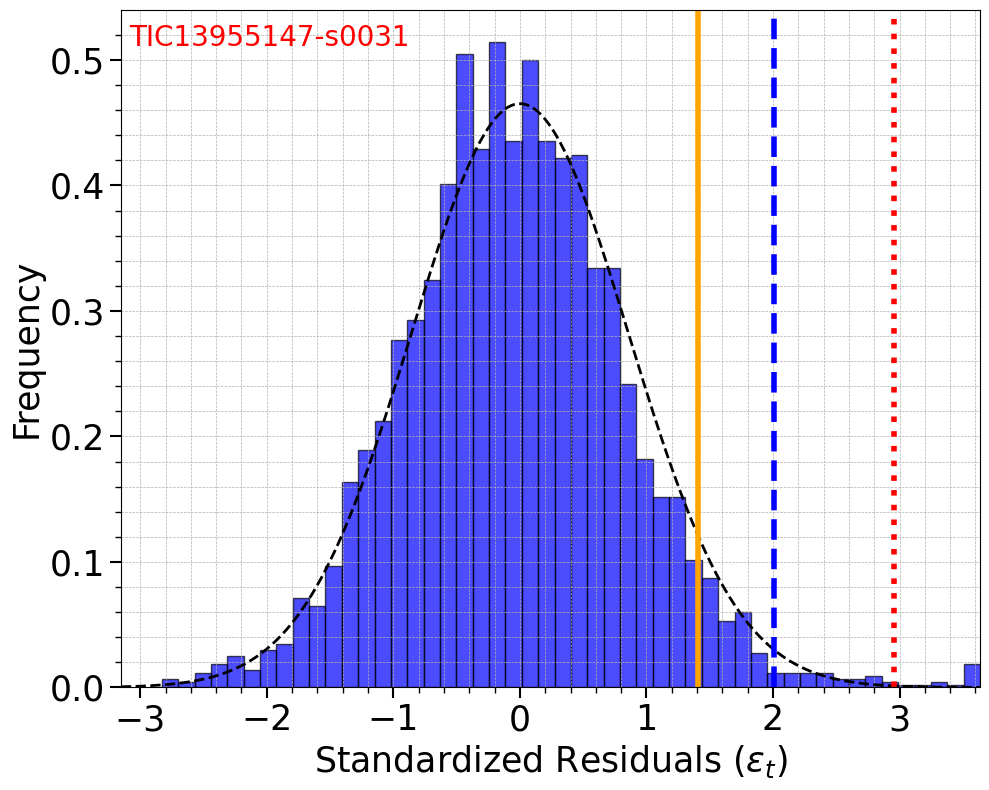

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.ticker import AutoMinorLocator


standardized_residuals = eps_all[eps_all != 0]
# Step 1: Compute the 99.95% empirical upper quantile
quantile_999 = np.percentile(standardized_residuals, 99.8)

# Step 2: Group values greater than 99.95% quantile by setting them to quantile_999
standardized_residuals_grouped = np.copy(standardized_residuals)
standardized_residuals_grouped[standardized_residuals > quantile_999] = quantile_999

# Step 3: Compute the 95% empirical upper quantile on the grouped data
quantile_95_grouped = np.percentile(standardized_residuals_grouped, 95)

# Step 4: Prepare data for normal distribution fitting
# Extract negative residuals from the grouped data
negative_residuals = standardized_residuals_grouped[standardized_residuals_grouped < 0]
# Mirror negative residuals to make them positive
mirrored_negative_residuals = -negative_residuals

# Extract positive residuals from the grouped data
positive_residuals = standardized_residuals_grouped[standardized_residuals_grouped > 0]

# Combine mirrored negative residuals with positive residuals to create symmetric data
symmetric_data = np.concatenate((negative_residuals, mirrored_negative_residuals))

# Step 5: Fit a normal distribution to the symmetric data
mu, std = norm.fit(symmetric_data)

# Step 6: Compute the 95% quantile from the fitted normal distribution
quantile_95_fitted = norm.ppf(0.95, loc=mu, scale=std)

# Step 7: Create a new figure for the distribution plot
fig_dist, ax_dist = plt.subplots(figsize=(10, 8))  # Adjust size as needed

# Step 8: Plot the histogram of the original full standardized residuals
ax_dist.hist(
    standardized_residuals_grouped,
    bins=50,                    # Number of bins can be adjusted
    color='blue',              # Updated color
    alpha=0.7,                  # Transparency for better visibility
    edgecolor='black',          # Outline color for bins
    density=True                # Normalize the histogram to form a probability density
)

# Step 9: Plot the fitted normal distribution
# Generate x values for the normal PDF based on the original data range
ax_dist.set_xlim(left=None, right=quantile_999)

# Retrieve the updated x-axis limits
xmin, xmax = ax_dist.get_xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu, std)

# Overlay the normal distribution
ax_dist.plot(x, p, 'k--', linewidth=2, label='Fitted Gaussian Curve')

# Step 10: Plot the vertical dashed orange line at the fitted 95% quantile
ax_dist.axvline(
    quantile_95_fitted,
    color='orange',               # Orange color for emphasis
    linestyle='-',               # Dashed line
    linewidth=4,                  # Thickness of the line
    label=f'95% Quantile (Fitted) = {quantile_95_fitted:.2f}'  # Label for the legend
)

# Step 11: Plot HB and BH thresholds (unchanged)
ax_dist.axvline(
    norm.ppf(1 - pHB, loc=mu, scale=std),
    color='red',                  # Red color for HB threshold
    linestyle=':',                # Dotted line
    linewidth=4,                  # Thickness of the line
    label='HB Threshold'          # Label for the legend
)

ax_dist.axvline(
    norm.ppf(1 - pBH, loc=mu, scale=std),
    color='blue',                 # Blue color for BH threshold
    linestyle='--',               # Dashed line
    linewidth=4,                  # Thickness of the line
    label='BH Threshold'          # Label for the legend
)

# Step 12: Add legend to the plot
#ax_dist.legend(fontsize=label_fontsize)

# Step 13: Set labels and title
ax_dist.set_xlabel("Standardized Residuals ($\\varepsilon_t$)", fontsize=label_fontsize)
ax_dist.set_ylabel("Frequency", fontsize=label_fontsize)
#ax_dist.set_title("Distribution of Standardized Residuals with Fitted Normal Distribution", fontsize=title_fontsize)

# Step 14: Customize ticks
ax_dist.tick_params(
    axis='both',
    which='major',
    length=8,
    width=1.5,
    labelsize=tick_fontsize
)
ax_dist.tick_params(
    axis='both',
    which='minor',
    length=4,
    width=1
)
ax_dist.minorticks_on()
ax_dist.xaxis.set_minor_locator(AutoMinorLocator(5))
ax_dist.yaxis.set_minor_locator(AutoMinorLocator(5))

# Step 15: Add red text label at top-left
ax_dist.text(
    0.01, 0.98, "TIC13955147-s0031", color='red', fontsize=20,
    transform=ax_dist.transAxes, va='top', ha='left'
)

# Step 16: Enable grid for better readability
ax_dist.grid(True, which="both", ls="--", linewidth=0.5)

# Step 17: Adjust layout to prevent clipping
plt.tight_layout()

# Step 18: Save the distribution plot
plt.savefig("TIC13955147_s0031_epsilon_distribution.pdf", dpi=300)

# Step 19: Show the distribution plot
plt.show()


In [19]:
import pandas as pd
import numpy as np
import os

# Specify the path to your text file
file_path = 'TIC13955147/hlsp_tess-spoc_tess_phot_0000000013955147-s0031_tess_v1_tp/hlsp_tess-spoc_tess_phot_0000000013955147-s0031_tess_v1_lc_new_FLARE.txt'
directory = os.path.dirname(file_path)

base_name = os.path.basename(file_path)
first_element = file_path.split('/')[0]  # "TIC269797536"
second_element = base_name.split('_')[3].split('-')[0]  # "s0039"

# Read the file explicitly specifying tab ('\t') as the delimiter
df = pd.read_csv(file_path, delimiter='\t')
print(df.head())

# Replace -999 with NaN in 'DE-HARMONIC' without inplace:
df['DE-HARMONIC'] = df['DE-HARMONIC'].replace(-999, np.nan)
print(df.head())

# Create a mask for rows where 'DE-HARMONIC' is missing (i.e. was -999 originally)
mask = df['DE-HARMONIC'].isna()

# Update the three columns to 0 for these rows
df.loc[mask, ['FLARE_HB', 'FLARE_BH', 'FLARE_candidate']] = 0

# Convert NaNs in 'DE-HARMONIC' back to -999 without inplace:
df['DE-HARMONIC'] = df['DE-HARMONIC'].fillna(-999)

noise_std = 0.04
last4_cols = df.columns[-4:]
df.loc[end, last4_cols] = df.iloc[end-1][last4_cols] + np.random.normal(0, noise_std, size=4)

# Save the updated DataFrame back to the original file with tab delimiter
df.to_csv(file_path, sep='\t', index=False)


          TIME  PDCSAP_FLUX  PDCSAP_FLUX_ERR  FLARE_HB  FLARE_BH  \
0  2144.519703     -999.000      -999.000000         0         0   
1  2144.526648    50586.492        11.702390         0         0   
2  2144.533592    50582.990        11.706409         0         0   
3  2144.540537    50587.460        11.702420         0         0   
4  2144.547482    50592.883        11.704536         0         0   

   FLARE_candidate  DE-HARMONIC         Zt  epsilont        pp  
0                0  -999.000000   0.000000  0.000000  0.000000  
1                0   -20.153772 -23.462299 -1.101738  1.796552  
2                0   -23.830985 -11.207111 -0.419631  1.371898  
3                0   -19.531254  -5.256522 -0.260469  1.236335  
4                0   -14.282725  -3.789599 -0.207947  1.189703  
          TIME  PDCSAP_FLUX  PDCSAP_FLUX_ERR  FLARE_HB  FLARE_BH  \
0  2144.519703     -999.000      -999.000000         0         0   
1  2144.526648    50586.492        11.702390         0         0 

In [20]:
df.iloc[end]

TIME                2169.943740
PDCSAP_FLUX        50430.150000
PDCSAP_FLUX_ERR       11.673281
FLARE_HB               0.000000
FLARE_BH               0.000000
FLARE_candidate        0.000000
DE-HARMONIC           -9.821621
Zt                    -7.251078
epsilont              -0.426865
pp                     1.411154
Name: 3661, dtype: float64